# Dataset 

In [1]:
import sys
sys.path.append('../datasets/')
from prepare_sequences import prepare, classes13, classes18
import matplotlib.pyplot as plt

classes = classes18

In [2]:
num_bands = 257
patch_len = 44                               # = 250ms ~ 25ms
patch_skip = 22                              # = 150ms ~ 15ms
seq_len = 60                                 # = 500ms with ~ 5 calls
seq_skip = 15
resize = (44, 44)

X_train, Y_train, X_test, Y_test, X_val, Y_val = prepare("../datasets/prepared.h5", classes, patch_len, patch_skip,
                                                         seq_len, seq_skip, resize)

100%|███████████████████████████████████████████| 18/18 [00:19<00:00,  1.08s/it]


In [3]:
print("Total sequences:", len(X_train) + len(X_test) + len(X_val))
print(X_train.shape, Y_train.shape)

Total sequences: 19259
(11357, 60, 44, 44) (11357,)


# Model

Sequence -> pos. encoding -> Transformer (CLS)

In [4]:
import time
import datetime
import numpy as np
import tqdm
import torch
import torch.nn as nn
import math
from torch.cuda.amp import autocast
from torch.utils.data import TensorDataset, DataLoader

In [19]:
use_mixedprecision = False
use_sampler = False
use_reduceonplateu = False
use_cosinescheduler = True

In [6]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [7]:
class Net(nn.Module):
    """
    Classifier based on a pytorch TransformerEncoder.
    """

    def __init__(
        self,
        max_len,
        d_model,
        num_classes,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):

        super().__init__()

        assert d_model % nhead == 0, "nheads must divide evenly into d_model"

        self.flatten = nn.Flatten(start_dim=-2, end_dim=-1)
        
        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            max_len=max_len,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, num_classes)
        self.d_model = d_model

    def forward(self, x):
        x = self.flatten(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [20]:
def train_epoch(model, epoch, criterion, optimizer, scheduler, dataloader, device):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
        # Transfer Data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
         
        # Clear the gradients
        optimizer.zero_grad()
        
        with autocast(enabled=use_mixedprecision):
            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # Calculate Loss
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (predictions == labels).sum().item()
    
        # Perform learning rate step
        if use_cosinescheduler:
            scheduler.step(epoch + batch / num_batches)
            
    epoch_loss = running_loss / num_samples
    epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [9]:
def test_epoch(model, epoch, criterion, optimizer, dataloader, device):
    model.eval()
    
    num_batches = len(dataloader)
    num_samples = len(dataloader.dataset)
    
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(tqdm.tqdm(dataloader)):
            # Transfer Data to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear the gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Update Weights
            optimizer.step()

            # Calculate Loss
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (predictions == labels).sum().item()

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects / num_samples
    
    return epoch_loss, epoch_acc

In [31]:
from torchsampler import ImbalancedDatasetSampler

batch_size = 24
epochs = 50
lr = 1e-4
warmup_epochs = 5

train_data = TensorDataset(torch.Tensor(X_train), torch.from_numpy(Y_train))
test_data = TensorDataset(torch.Tensor(X_test), torch.from_numpy(Y_test))
val_data = TensorDataset(torch.Tensor(X_val), torch.from_numpy(Y_val))

if use_sampler:
    train_loader = DataLoader(train_data, sampler=ImbalancedDatasetSampler(train_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=ImbalancedDatasetSampler(test_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=ImbalancedDatasetSampler(val_data), batch_size=batch_size)
else:
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    val_loader = DataLoader(val_data, batch_size=batch_size)

In [32]:
model = Net(
    max_len=seq_len,
    d_model=resize[0]*resize[1], # patch_len * num_bands, # 44 * 257 = 11,308
    num_classes=len(list(classes)),
    nhead=4,
    dim_feedforward=64,
    num_layers=1,
    dropout=0.5,
    classifier_dropout=0.5,
)
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(device)

cuda:0


In [33]:
import wandb

wandb.init(project="BAT-1", entity="frankfundel")

wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

criterion = nn.CrossEntropyLoss() # has softmax in it

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr
)

scheduler = None
if use_cosinescheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=warmup_epochs, T_mult=1)
if use_reduceonplateu:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
min_val_loss = np.inf

torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    end = time.time()
    print(f"==================== Starting at epoch {epoch} ====================", flush=True)
    
    train_loss, train_acc = train_epoch(model, epoch, criterion, optimizer, scheduler, train_loader, device)
    print('Training loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc), flush=True)
    
    val_loss, val_acc = test_epoch(model, epoch, criterion, optimizer, val_loader, device)
    print('Validation loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc), flush=True)
    
    if use_reduceonplateu:
        scheduler.step(val_loss)
    
    wandb.log({
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    if min_val_loss > val_loss:
        print('val_loss decreased, saving model', flush=True)
        min_val_loss = val_loss
         
        # Saving State Dict
        torch.save(model.state_dict(), 'bat_1.pth')

train_acc,▁█████
train_loss,█▃▂▂▁▁
val_acc,▁▁▁▁▁█
val_loss,█▇▅▅▅▁
train_acc,0.18218
train_loss,2.59161
val_acc,0.17972
val_loss,2.60754


==================== Starting at epoch 0 ====================


100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.72it/s]

Training loss: 2.0540 Acc: 0.3416



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 33.70it/s]

Validation loss: 4.1449 Acc: 0.1828
val_loss decreased, saving model


==================== Starting at epoch 1 ====================


100%|█████████████████████████████████████████| 474/474 [00:42<00:00, 11.14it/s]

Training loss: 1.4249 Acc: 0.5315



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.81it/s]

Validation loss: 1.8213 Acc: 0.4288
val_loss decreased, saving model


==================== Starting at epoch 2 ====================


100%|█████████████████████████████████████████| 474/474 [00:38<00:00, 12.21it/s]

Training loss: 1.2195 Acc: 0.6028



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.59it/s]

Validation loss: 1.8654 Acc: 0.4481
==================== Starting at epoch 3 ====================



100%|█████████████████████████████████████████| 474/474 [00:41<00:00, 11.34it/s]

Training loss: 1.1283 Acc: 0.6369



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.54it/s]

Validation loss: 1.3294 Acc: 0.5564
val_loss decreased, saving model


==================== Starting at epoch 4 ====================


100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.12it/s]

Training loss: 1.0900 Acc: 0.6489



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.66it/s]

Validation loss: 1.3041 Acc: 0.5705
val_loss decreased, saving model


==================== Starting at epoch 5 ====================


100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.58it/s]

Training loss: 1.1937 Acc: 0.5984



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 40.31it/s]

Validation loss: 7.1764 Acc: 0.3049
==================== Starting at epoch 6 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.72it/s]

Training loss: 1.0986 Acc: 0.6380



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 37.84it/s]

Validation loss: 1.9568 Acc: 0.4343
==================== Starting at epoch 7 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.65it/s]

Training loss: 0.9551 Acc: 0.6828



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.77it/s]

Validation loss: 1.7486 Acc: 0.5067
==================== Starting at epoch 8 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.79it/s]

Training loss: 0.8877 Acc: 0.7150



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 38.62it/s]

Validation loss: 1.2230 Acc: 0.6068
val_loss decreased, saving model


==================== Starting at epoch 9 ====================


100%|█████████████████████████████████████████| 474/474 [00:42<00:00, 11.28it/s]

Training loss: 0.8546 Acc: 0.7263



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 43.00it/s]

Validation loss: 1.2177 Acc: 0.6133
val_loss decreased, saving model


==================== Starting at epoch 10 ====================


100%|█████████████████████████████████████████| 474/474 [00:41<00:00, 11.36it/s]

Training loss: 0.9733 Acc: 0.6680



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.96it/s]

Validation loss: 6.2076 Acc: 0.2839
==================== Starting at epoch 11 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.83it/s]

Training loss: 0.8891 Acc: 0.6974



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 40.16it/s]

Validation loss: 2.5850 Acc: 0.4181
==================== Starting at epoch 12 ====================



100%|█████████████████████████████████████████| 474/474 [00:41<00:00, 11.49it/s]

Training loss: 0.7746 Acc: 0.7443



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.82it/s]

Validation loss: 1.7212 Acc: 0.5336
==================== Starting at epoch 13 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.79it/s]

Training loss: 0.7078 Acc: 0.7725



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 37.13it/s]

Validation loss: 1.1454 Acc: 0.6440
val_loss decreased, saving model


==================== Starting at epoch 14 ====================


100%|█████████████████████████████████████████| 474/474 [00:38<00:00, 12.22it/s]

Training loss: 0.6735 Acc: 0.7852



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.27it/s]

Validation loss: 1.1477 Acc: 0.6468
==================== Starting at epoch 15 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.01it/s]

Training loss: 0.8257 Acc: 0.7152



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 37.73it/s]

Validation loss: 9.3403 Acc: 0.1966
==================== Starting at epoch 16 ====================



100%|█████████████████████████████████████████| 474/474 [00:41<00:00, 11.55it/s]

Training loss: 0.7686 Acc: 0.7407



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.79it/s]

Validation loss: 1.9873 Acc: 0.5095
==================== Starting at epoch 17 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.12it/s]

Training loss: 0.6300 Acc: 0.7876



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 38.80it/s]

Validation loss: 1.4727 Acc: 0.5992
==================== Starting at epoch 18 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.60it/s]

Training loss: 0.5717 Acc: 0.8198



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.12it/s]

Validation loss: 1.0998 Acc: 0.6661
val_loss decreased, saving model


==================== Starting at epoch 19 ====================


100%|█████████████████████████████████████████| 474/474 [00:43<00:00, 10.85it/s]

Training loss: 0.5452 Acc: 0.8313



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.64it/s]

Validation loss: 1.1198 Acc: 0.6713
==================== Starting at epoch 20 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.84it/s]

Training loss: 0.7296 Acc: 0.7504



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.61it/s]

Validation loss: 4.0336 Acc: 0.3267
==================== Starting at epoch 21 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.91it/s]

Training loss: 0.6266 Acc: 0.7854



100%|█████████████████████████████████████████| 121/121 [00:04<00:00, 27.55it/s]

Validation loss: 2.5810 Acc: 0.4695
==================== Starting at epoch 22 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.95it/s]

Training loss: 0.5293 Acc: 0.8272



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 39.24it/s]

Validation loss: 1.4320 Acc: 0.6209
==================== Starting at epoch 23 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.10it/s]

Training loss: 0.4686 Acc: 0.8552



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 30.83it/s]

Validation loss: 1.0850 Acc: 0.6826
val_loss decreased, saving model


==================== Starting at epoch 24 ====================


100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.61it/s]

Training loss: 0.4414 Acc: 0.8652



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 37.77it/s]

Validation loss: 1.1056 Acc: 0.6892
==================== Starting at epoch 25 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.81it/s]

Training loss: 0.6390 Acc: 0.7743



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.30it/s]

Validation loss: 3.2851 Acc: 0.3781
==================== Starting at epoch 26 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.63it/s]

Training loss: 0.5371 Acc: 0.8201



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.79it/s]

Validation loss: 3.2149 Acc: 0.4481
==================== Starting at epoch 27 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.74it/s]

Training loss: 0.4523 Acc: 0.8537



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.80it/s]

Validation loss: 1.4067 Acc: 0.6447
==================== Starting at epoch 28 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.91it/s]

Training loss: 0.3928 Acc: 0.8774



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 38.11it/s]

Validation loss: 1.0797 Acc: 0.6940
val_loss decreased, saving model


==================== Starting at epoch 29 ====================


100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.06it/s]

Training loss: 0.3636 Acc: 0.8924



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 36.10it/s]

Validation loss: 1.1104 Acc: 0.6933
==================== Starting at epoch 30 ====================



100%|█████████████████████████████████████████| 474/474 [00:42<00:00, 11.16it/s]

Training loss: 0.5801 Acc: 0.7969



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.79it/s]

Validation loss: 3.1981 Acc: 0.4553
==================== Starting at epoch 31 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.66it/s]

Training loss: 0.4647 Acc: 0.8445



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 33.73it/s]

Validation loss: 2.5434 Acc: 0.4912
==================== Starting at epoch 32 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.07it/s]

Training loss: 0.3895 Acc: 0.8763



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.02it/s]

Validation loss: 1.3202 Acc: 0.6554
==================== Starting at epoch 33 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.77it/s]

Training loss: 0.3324 Acc: 0.9014



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 36.87it/s]

Validation loss: 1.1236 Acc: 0.6927
==================== Starting at epoch 34 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.89it/s]

Training loss: 0.3048 Acc: 0.9160



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.47it/s]

Validation loss: 1.1132 Acc: 0.7027
==================== Starting at epoch 35 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.80it/s]

Training loss: 0.5343 Acc: 0.8141



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 35.19it/s]

Validation loss: 3.7489 Acc: 0.4488
==================== Starting at epoch 36 ====================



100%|█████████████████████████████████████████| 474/474 [00:42<00:00, 11.28it/s]

Training loss: 0.4297 Acc: 0.8574



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.19it/s]

Validation loss: 3.7217 Acc: 0.4412
==================== Starting at epoch 37 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.88it/s]

Training loss: 0.3503 Acc: 0.8885



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 36.98it/s]

Validation loss: 1.3216 Acc: 0.6623
==================== Starting at epoch 38 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.98it/s]

Training loss: 0.2811 Acc: 0.9209



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 38.35it/s]

Validation loss: 1.1402 Acc: 0.6975
==================== Starting at epoch 39 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.06it/s]

Training loss: 0.2606 Acc: 0.9291



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 40.73it/s]

Validation loss: 1.1308 Acc: 0.7009
==================== Starting at epoch 40 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.04it/s]

Training loss: 0.5417 Acc: 0.8144



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.30it/s]

Validation loss: 12.6969 Acc: 0.2491
==================== Starting at epoch 41 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.69it/s]

Training loss: 0.4170 Acc: 0.8670



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 40.03it/s]

Validation loss: 2.4237 Acc: 0.5171
==================== Starting at epoch 42 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.71it/s]

Training loss: 0.2983 Acc: 0.9090



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.64it/s]

Validation loss: 1.3352 Acc: 0.6657
==================== Starting at epoch 43 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.10it/s]

Training loss: 0.2459 Acc: 0.9288



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.31it/s]

Validation loss: 1.1480 Acc: 0.6985
==================== Starting at epoch 44 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.91it/s]

Training loss: 0.2251 Acc: 0.9398



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 41.90it/s]

Validation loss: 1.1536 Acc: 0.7071
==================== Starting at epoch 45 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 12.03it/s]

Training loss: 0.4956 Acc: 0.8252



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 32.40it/s]

Validation loss: 4.5032 Acc: 0.4136
==================== Starting at epoch 46 ====================



100%|█████████████████████████████████████████| 474/474 [00:39<00:00, 11.86it/s]

Training loss: 0.3425 Acc: 0.8875



100%|█████████████████████████████████████████| 121/121 [00:02<00:00, 42.53it/s]

Validation loss: 2.8794 Acc: 0.5492
==================== Starting at epoch 47 ====================



100%|█████████████████████████████████████████| 474/474 [00:38<00:00, 12.26it/s]

Training loss: 0.2674 Acc: 0.9157



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 37.80it/s]

Validation loss: 1.2439 Acc: 0.6785


==================== Starting at epoch 48 ====================


100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.82it/s]

Training loss: 0.2156 Acc: 0.9402



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 34.80it/s]

Validation loss: 1.1380 Acc: 0.7085
==================== Starting at epoch 49 ====================



100%|█████████████████████████████████████████| 474/474 [00:40<00:00, 11.76it/s]

Training loss: 0.1983 Acc: 0.9463



100%|█████████████████████████████████████████| 121/121 [00:03<00:00, 36.07it/s]

Validation loss: 1.1590 Acc: 0.7147


In [34]:
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, 'bat_1.pt')

/home/ffundel/.local/lib/python3.8/site-packages/torch/jit/_recursive.py:240: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Y_pred = []
Y_true = []
corrects = 0

model.eval()

# iterate over test data
for inputs, labels in tqdm.tqdm(test_loader):
        output = model(inputs.cuda()) # Feed Network
        
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        Y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        Y_true.extend(labels) # Save Truth

100%|█████████████████████████████████████████| 209/209 [00:14<00:00, 14.20it/s]


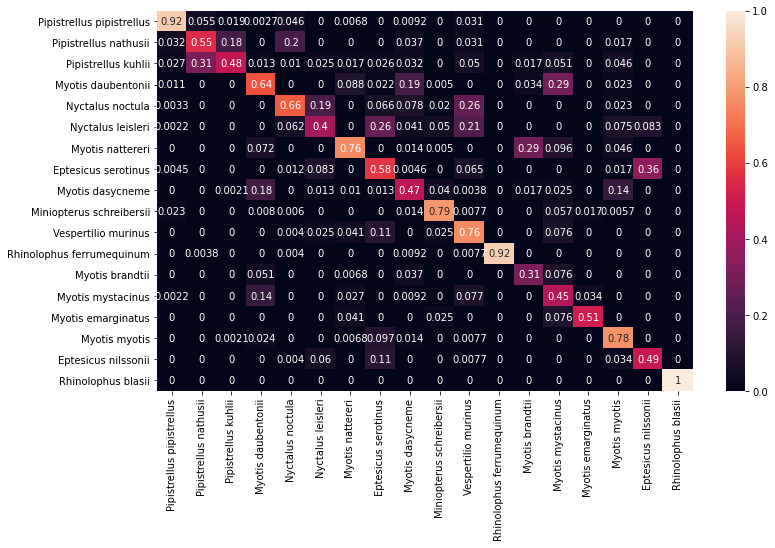

In [36]:
# Build confusion matrix
cf_matrix = confusion_matrix(Y_true, Y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=-1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('bat_1_cf.png')

In [37]:
corrects = np.equal(Y_pred, Y_true).sum()
print("Test accuracy:", corrects/len(Y_pred))

Test accuracy: 0.6598041175294823
